In [20]:
seed=42
import numpy as np
import logging
import seaborn as sns
import matplotlib as mpl
import pandas as pd
np.random.seed(42)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(f"TensorFlow version {tf.__version__}")

TensorFlow version 2.18.0


In [2]:
train_data=np.loadtxt("/content/drive/MyDrive/Compstats_proj-main/data/Sunspot/train.txt")
test_data=np.loadtxt("/content/drive/MyDrive/Compstats_proj-main/data/Sunspot/test.txt")

In [3]:
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
X_test = test_data[:,:-1]
y_test = test_data[:,-1]


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    x_data,
    y_data,
    test_size = 0.1, # Ensure validation set size matches test set size
    random_state=42
)


In [5]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((268, 4), (30, 4), (268,), (30,))

In [6]:
max_df=X_train.max()
max_target=y_train.max()
min_df=X_train.min()
min_target=y_train.min()

In [7]:
X_train = (X_train - min_df)/(max_df - min_df)
X_val = (X_val - min_df)/(max_df - min_df)
X_test = (X_test - min_df)/(max_df - min_df)


y_train = (y_train - min_target)/(max_target - min_target)
y_val = (y_val - min_target)/(max_target - min_target)
y_test = (y_test - min_target)/(max_target - min_target)

In [8]:
# Define a function for plotting training and validation Mean Squared Error (MSE) histories.
def plot_histories(metadata, training=False, baseline=False, show_all=False):

    print('VALIDATION MSE')
    plt.figure(figsize=(21, 9))

    # Iterate through different models stored in metadata.
    for model in list(metadata.keys()):

        # Skip the baseline model if baseline flag is False.
        if model == 'Baseline' and not baseline:
            continue

        # Retrieve relevant information from the metadata dictionary.
        history = metadata[model]['history']
        patience = metadata[model]['patience']
        color = metadata[model]['color']
        val_score = metadata[model]['val_score']
        print('%s: %.4f' % (model, val_score))

        # Plot training and validation MSE histories with or without patience handling.
        if patience != 0:
            if training:
                plt.plot(
                    history['mse'][:-patience],
                    alpha=0.5,
                    color=color
                )
                if show_all:
                    plt.plot(
                        np.arange(len(history['mse']) - patience - 1, len(history['mse'])),
                        history['mse'][-patience - 1:],
                        alpha=0.2,
                        color=color
                    )

            plt.plot(
                history['val_mse'][:-patience],
                label=model,
                alpha=0.9,
                color=color
            )
            if show_all:
                plt.plot(
                    np.arange(len(history['val_mse']) - patience - 1, len(history['val_mse'])),
                    history['val_mse'][-patience - 1:],
                    alpha=0.2,
                    color=color
                )

        else:
            if training:
                plt.plot(
                    history['mse'],
                    alpha=0.5,
                    color=color
                )
            plt.plot(
                history['val_mse'],
                label=model,
                alpha=0.9,
                color=color
            )

        # Set y-axis limits and add labels, legends, and grid.
        if training:
            plt.ylim(0.004, 0.0225)
        else:
            plt.ylim(0.01, 0.025)
        plt.title('Mean Squared Error')
        plt.legend(loc='upper right')
        plt.grid(alpha=0.3)

    # Display the plot.
    plt.show()

In [9]:
'''
# Define a function for plotting residuals and model predictions
def plot_residuals(model, data, labels):
    # Sort the data and labels based on the 'labels' column
    data['sort'] = labels
    data = data.sort_values(by=['sort'])
    labels = np.expand_dims(data['sort'], 1)
    data.drop(['sort'], axis=1, inplace=True)

    # Make predictions using the model
    y_pred = model.predict(data, verbose=0)

    # Calculate squared errors and mean squared error (MSE)
    squared_errors = (labels - y_pred)**2
    mse = np.mean(squared_errors).astype('float32')
    print('MSE: %.4f' % mse)

    # Set up plotting styles and create a scatter plot
    mpl.rcParams.update(mpl.rcParamsDefault)
    sns.set(font_scale=1.1, style=None, palette='Set1')
    plt.figure(figsize=(21, 5))

    # Plot true labels in red and model predictions in blue
    plt.scatter(np.arange(len(labels)), labels, label='True', color='#d62728', alpha=0.7, s=8)

    # Add vertical lines to represent residuals
    for i in range(len(labels)):
        if labels[i] >= y_pred[i]:
            plt.vlines(i, y_pred[i], labels[i], alpha=0.2, linewidth=0.5)
        else:
            plt.vlines(i, labels[i], y_pred[i], alpha=0.2, linewidth=0.5)

    plt.scatter(np.arange(len(y_pred)), y_pred, label='Prediction', color='#1f77b4', s=8)

    # Add legends, grid, and set y-axis limits
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim((-0.1, 1.1))
    plt.show()
    '''

In [18]:
def plot_residuals(model, x_train, y_train):
    # Sort x_train and y_train based on y_train values
    sorted_indices = np.argsort(y_train, axis=0).flatten()
    x_sorted = x_train[sorted_indices]
    y_sorted = y_train[sorted_indices]

    # Make predictions using the model
    y_pred = model.predict(x_sorted, verbose=0)

    # Ensure y arrays are 1D for calculations and plotting
    y_sorted = y_sorted.squeeze()
    y_pred = y_pred.squeeze()

    # Calculate squared errors and MSE
    squared_errors = (y_sorted - y_pred) ** 2
    mse = np.mean(squared_errors).astype('float32')
    print('MSE: %.4f' % mse)

    # Set up plotting
    mpl.rcParams.update(mpl.rcParamsDefault)
    sns.set(font_scale=1.1, style=None, palette='Set1')
    plt.figure(figsize=(21, 5))

    # Plot true values
    plt.scatter(np.arange(len(y_sorted)), y_sorted,
                label='True', color='#d62728', alpha=0.7, s=8)

    # Add vertical residual lines
    for i in range(len(y_sorted)):
        if y_sorted[i] >= y_pred[i]:
            plt.vlines(i, y_pred[i], y_sorted[i],
                      alpha=0.2, linewidth=0.5)
        else:
            plt.vlines(i, y_sorted[i], y_pred[i],
                      alpha=0.2, linewidth=0.5)

    # Plot predicted values
    plt.scatter(np.arange(len(y_pred)), y_pred,
                label='Prediction', color='#1f77b4', s=8)

    # Configure plot
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim((-0.1, 1.1))
    plt.show()

In [10]:
def evaluate_and_plot_model(model, X_val, y_val, X_test, y_test, metadata, history, patience, model_name, color, plot_baseline=False):
    # Calculate validation Mean Squared Error (MSE) for the model
    val_predictions = np.squeeze(model.predict(X_val, verbose=0))
    val_squared_errors = (y_val - val_predictions)**2
    val_mse = np.mean(val_squared_errors).astype('float32')

    # Calculate test Mean Squared Error (MSE) for the model
    test_predictions = np.squeeze(model.predict(X_test, verbose=0))
    test_squared_errors = (y_test - test_predictions)**2
    test_mse = np.mean(test_squared_errors).astype('float32')

    # Add model metadata to the dictionary
    metadata[model_name] = {
        'model': model,
        'history': history,
        'color': color,
        'patience': patience,
        'val_score': val_mse,
        'test_score': test_mse
    }

    # Plot histories
    plot_histories(metadata, baseline=plot_baseline)

    return metadata

In [25]:
def build_model(input_shape, learning_rate=1e-3, name='', seed=seed):

    # Set random seed for reproducibility
    tf.random.set_seed(seed)

    # Initialise weights and regulariser
    initialiser = tfk.initializers.GlorotNormal(seed=seed)
    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    # Hidden layers with ReLU activations
    x = tfkl.Dense(units=10, name='HiddenDense1', kernel_initializer=initialiser)(input_layer)
    x = tfkl.Activation('sigmoid', name='HiddenActivation1')(x)

    output_layer = tfkl.Dense(units=1, kernel_initializer=initialiser, name='Output')(x)

    # Linear output activation
    output_activation = tfkl.Activation('linear', name='OutputActivation')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name=name)

    # Compile the model with Adam optimiser and MSE loss
    opt = tfk.optimizers.Adam(learning_rate)
    loss = tfk.losses.MeanSquaredError()
    mtr = ['mse']
    model.compile(loss=loss, optimizer=opt, metrics=mtr)

    # Return the compiled model
    return model

In [26]:
input_shape = X_train.shape[1:]

# Define the batch size for training
batch_size = 64

# Define the number of training epochs
epochs = 500

# Create an empty dictionary to store metadata
metadata = {}

Model: ""

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 4)                    │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ HiddenDense1 (Dense)                │ (None, 10)                   │            50 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ HiddenActivation1 (Activation)      │ (None, 10)                   │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Output (Dense)                      │ (None, 1)                    │            11 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ OutputActivation (Activation)       │ (None, 1)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

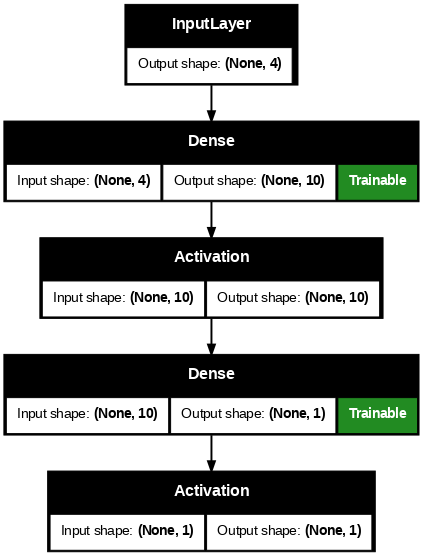

In [27]:
model = build_model(input_shape)
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [28]:
history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    verbose=1
).history

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0904 - mse: 0.0904 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0562 - mse: 0.0562 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0397 - mse: 

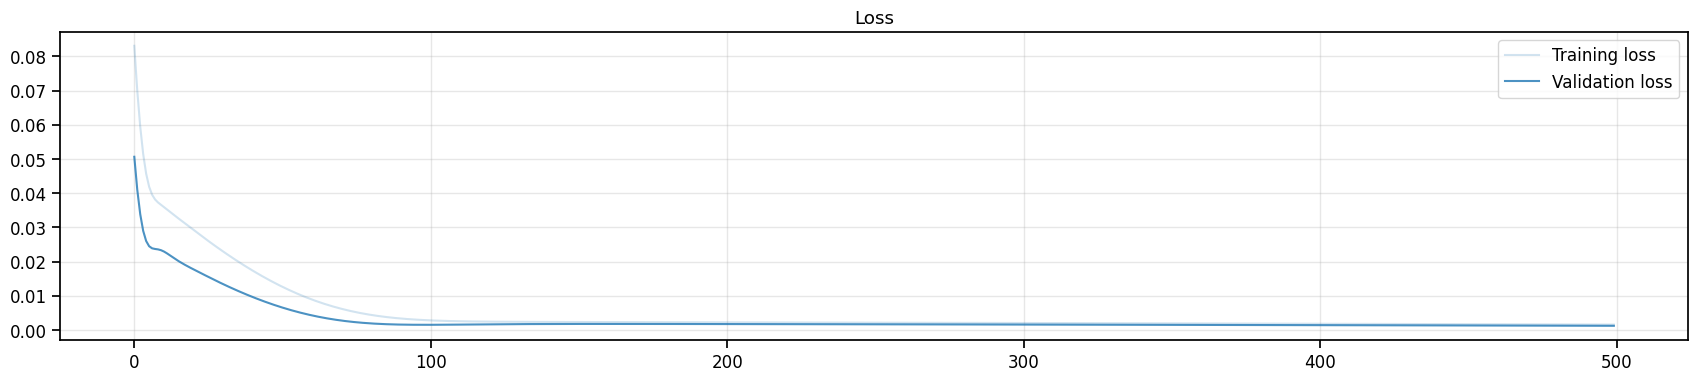

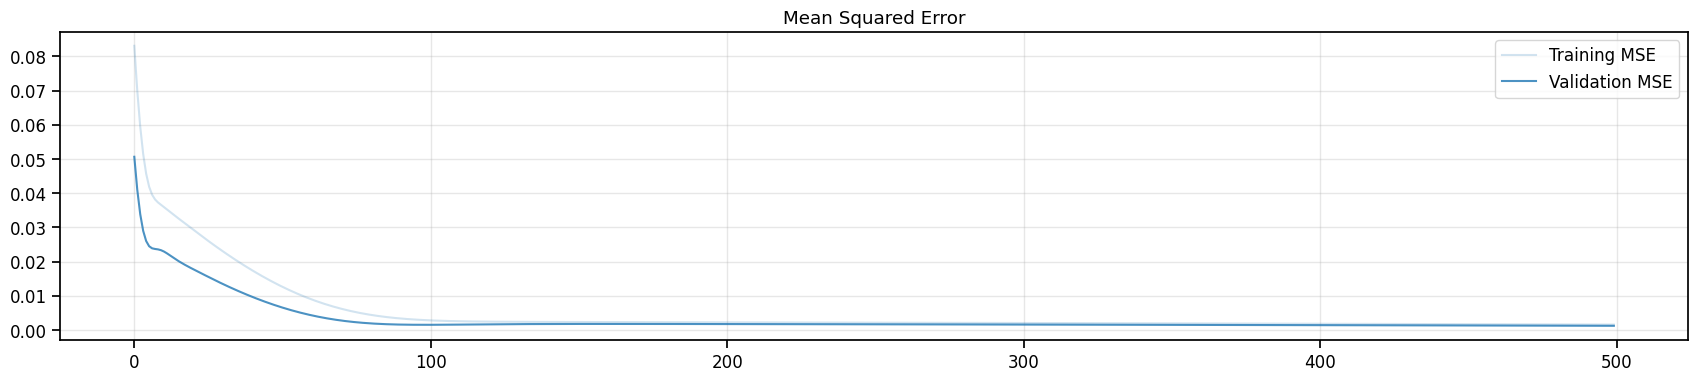

In [29]:
ignore = 0

# Create a figure for loss visualization
plt.figure(figsize=(21, 4))

# Plot training and validation loss
plt.plot(history['loss'][ignore:], label='Training loss', alpha=.2, color='#1f77b4')
plt.plot(history['val_loss'][ignore:], label='Validation loss', alpha=.8, color='#1f77b4')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Create a figure for Mean Squared Error visualization
plt.figure(figsize=(21, 4))

# Plot training and validation MSE
plt.plot(history['mse'][ignore:], label='Training MSE', alpha=.2, color='#1f77b4')
plt.plot(history['val_mse'][ignore:], label='Validation MSE', alpha=.8, color='#1f77b4')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)

# Display the plots
plt.show()

VALIDATION MSE
Baseline: 0.0013


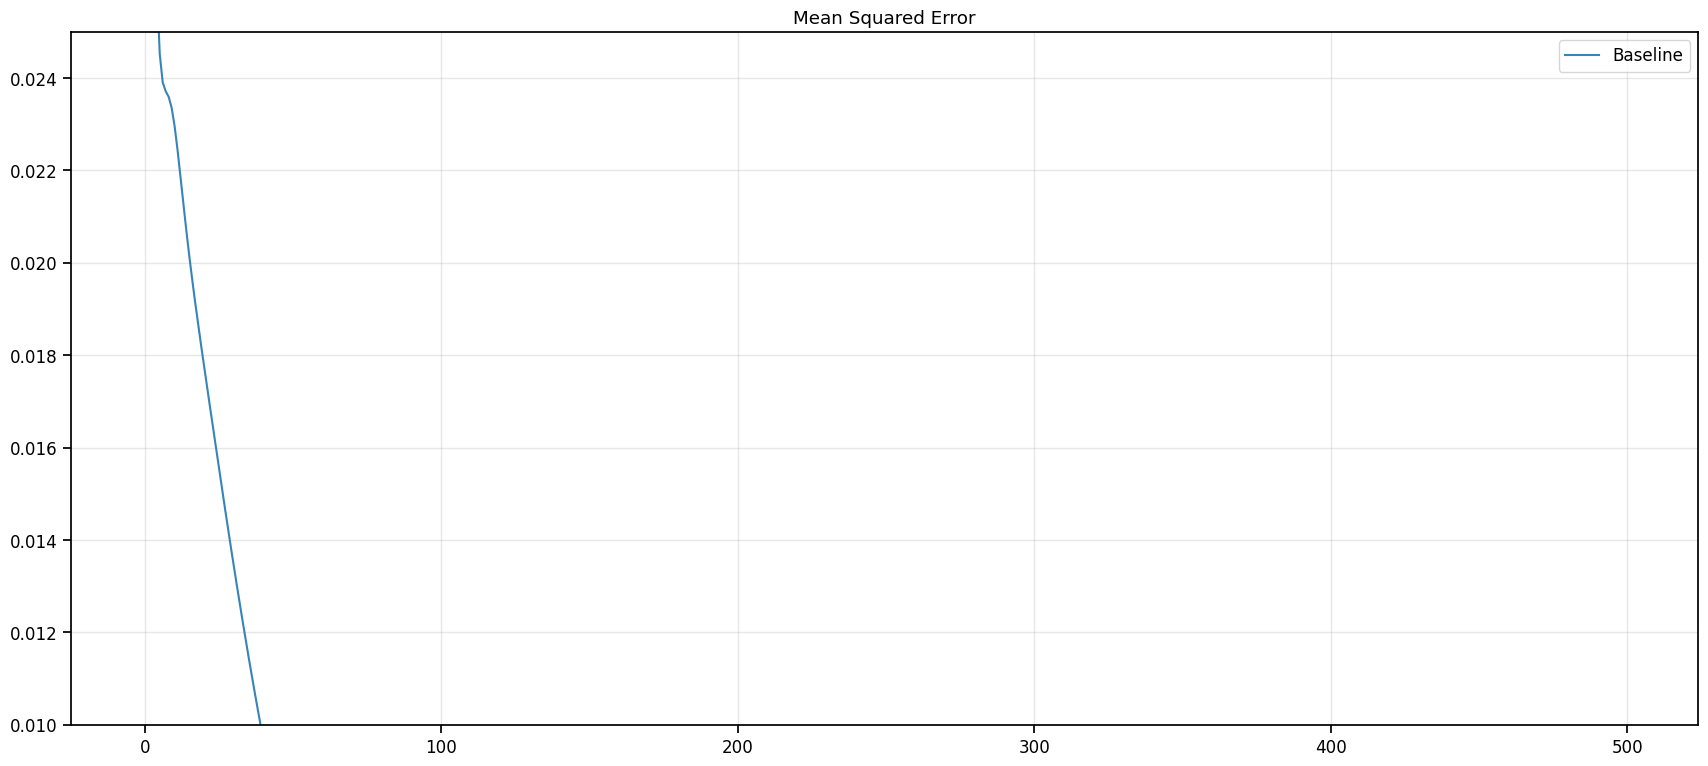

In [30]:
metadata = evaluate_and_plot_model(
    model,
    X_val,
    y_val,
    X_test,
    y_test,
    metadata,
    history=history,
    patience=0,
    model_name='Baseline',
    color='#1f77b4',
    plot_baseline=True
    )

# Calculate the final validation mse
final_val_mse = round(history['val_mse'][-1], 4)

# Save the trained model to a file with the mse included in the filename
model_filename = f'Feedforward_{final_val_mse}.keras'
model.save(model_filename)

# Delete the model to free up memory resources


Train Performance
MSE: 0.0016


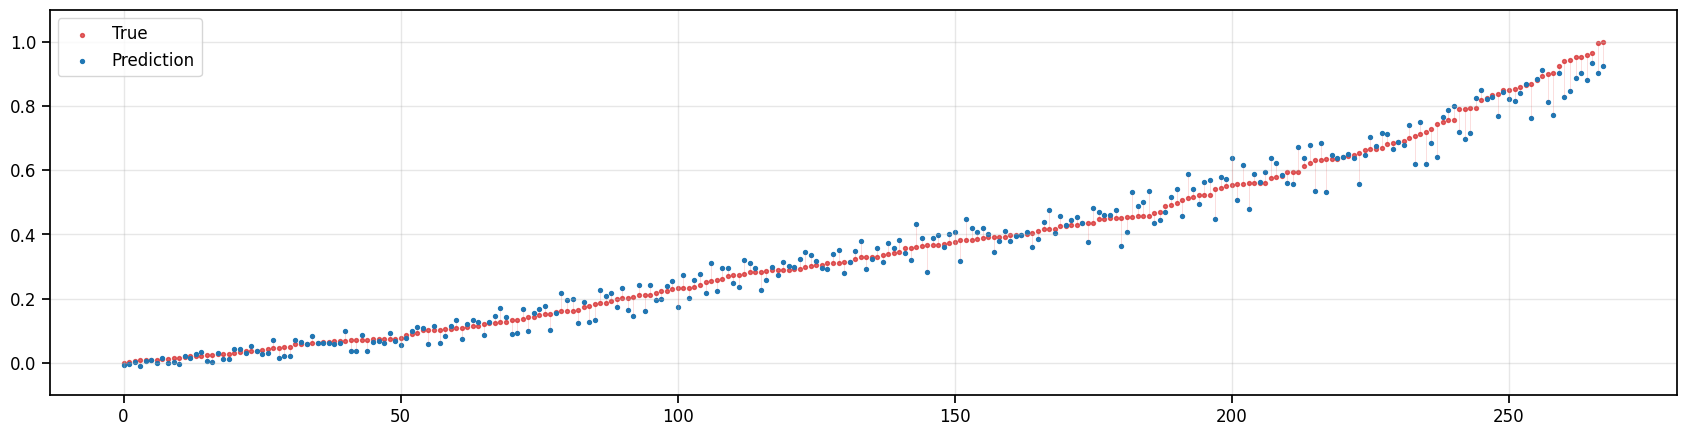

Validation Performance
MSE: 0.0013


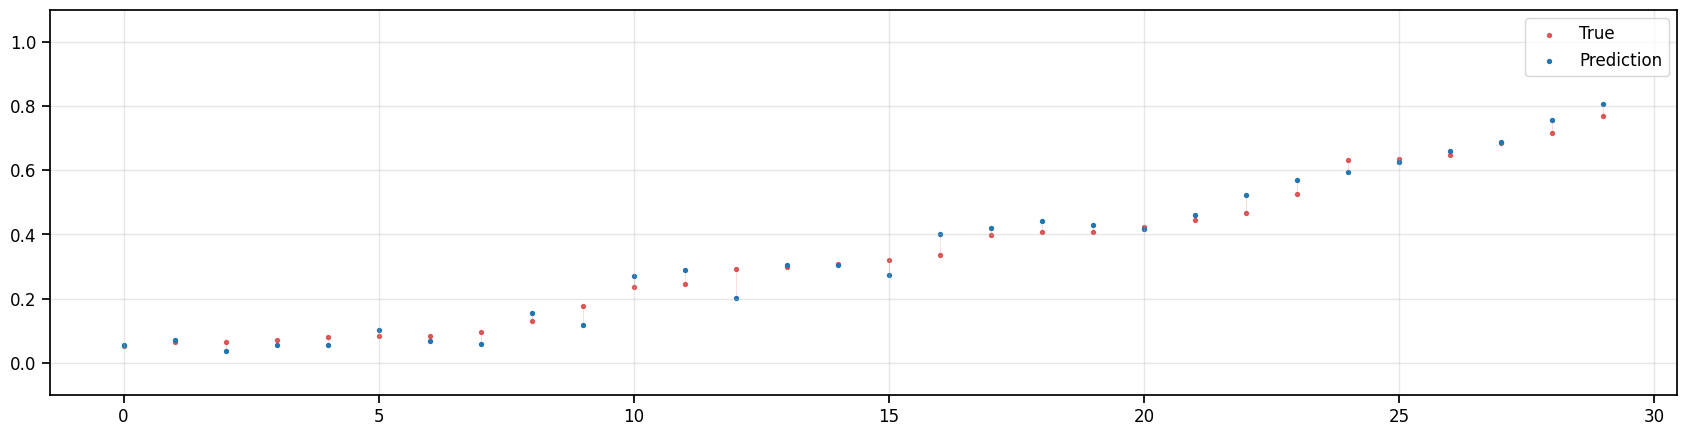

Test Performance
MSE: 0.0007


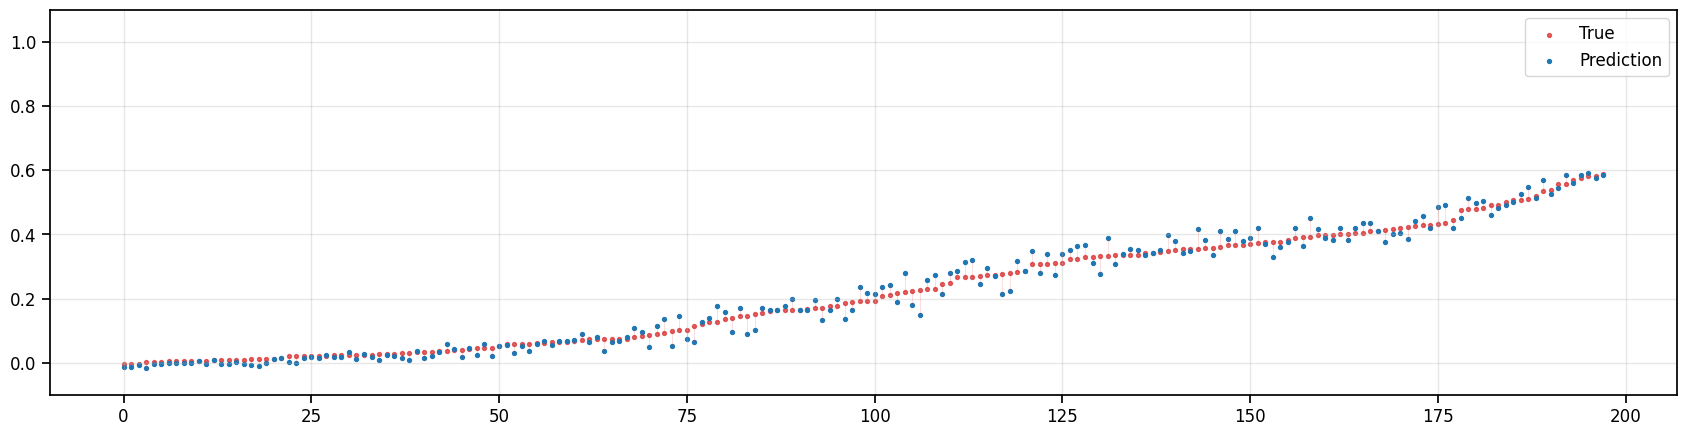

In [31]:

# Evaluate and plot performance on the training data
print('Train Performance')
plot_residuals(model, X_train.copy(), y_train.copy())

# Evaluate and plot performance on the validation data
print('Validation Performance')
plot_residuals(model, X_val.copy(), y_val.copy())

# Evaluate and plot performance on the test data
print('Test Performance')
plot_residuals(model, X_test.copy(), y_test.copy())